In [1]:
import os
import torch
import torchvision.transforms as T
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Mount Google Drive and Paths to folders and model
drive.mount('/content/drive')
image_folder = "/content/drive/MyDrive/DL Project/Pics/images"
mask_folder = "/content/drive/MyDrive/DL Project/Pics/annotation_mask"
device = torch.device("cuda")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define class colors
label_colors = {
    "background": (0, 0, 0),
    "grilled chicken": (255, 0, 0),
    "paneer": (0, 255, 0),
    "eggplant": (0, 0, 255)
}
color_to_class = {v: i for i, (k, v) in enumerate(
    label_colors.items())}

In [5]:
# Custom Dataset Class
class FoodSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir)
                       if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        mask = self.rgb_to_class_indices(mask)

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def rgb_to_class_indices(self, mask):
        mask_np = np.array(mask)
        class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]),
                              dtype=np.int64)
        for color, class_idx in color_to_class.items():
            class_mask[(mask_np == color).all(axis=2)] = class_idx
        return class_mask


In [6]:
# Data transformations
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
])


In [7]:
# Load dataset and split
dataset = FoodSegmentationDataset(image_folder, mask_folder, 
                                  transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, 
                                                           [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
# EfficientNet model class
class EfficientNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetSegmentation, self).__init__()
        self.backbone = torchvision.models.efficientnet_b0(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Conv2d(1280, num_classes, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        # Freeze all layers
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [10]:
# Initialize the model with the number of classes
model = EfficientNetSegmentation(num_classes=len(label_colors)).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 164MB/s]


In [11]:
# Criterion for evaluating performance
criterion = nn.CrossEntropyLoss()

In [12]:
# Evaluation and loss calculation function
def evaluate_model(model, loader, criterion):
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_batches += 1
    avg_loss = total_loss / total_batches
    return avg_loss

In [13]:
# Calculate Training Loss and Validation loss
train_loss = evaluate_model(model, train_loader, criterion)
val_loss = evaluate_model(model, val_loader, criterion)

In [21]:
# Visualization function for predictions
def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            pred_rgb = np.zeros((preds[0].shape[0], preds[0].shape[1], 3), dtype=np.uint8)
            mask_rgb = np.zeros((masks[0].shape[0], masks[0].shape[1], 3), dtype=np.uint8)

            for color, class_idx in color_to_class.items():
                pred_rgb[preds[0] == class_idx] = color
                mask_rgb[masks[0].cpu().numpy() == class_idx] = color

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0].cpu().permute(1, 2, 0))
            axs[0].set_title("Input Image")
            axs[1].imshow(mask_rgb)
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred_rgb)
            axs[2].set_title("Prediction Mask")
            plt.show()



Average Training Loss: 1.491151797771454
Average Validation Loss: 1.50767240524292
Visualizing Predictions on Validation Data:


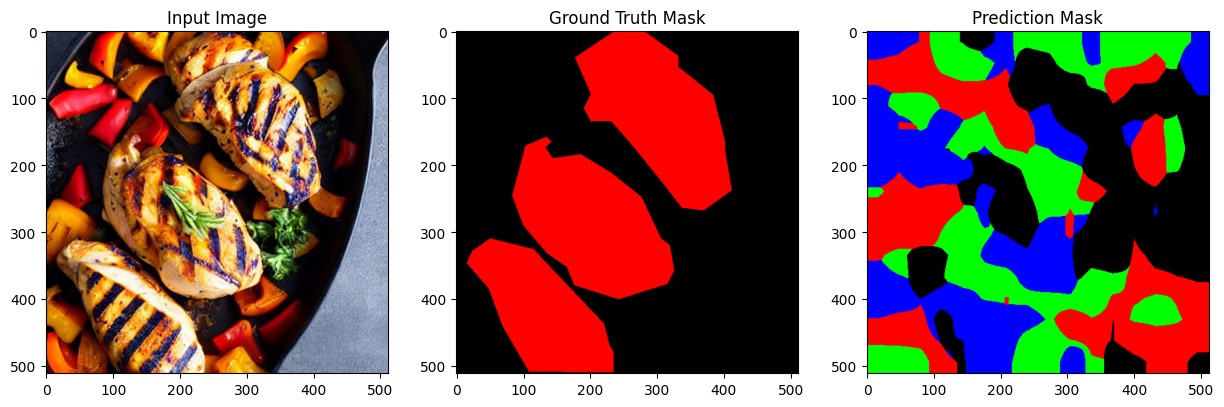

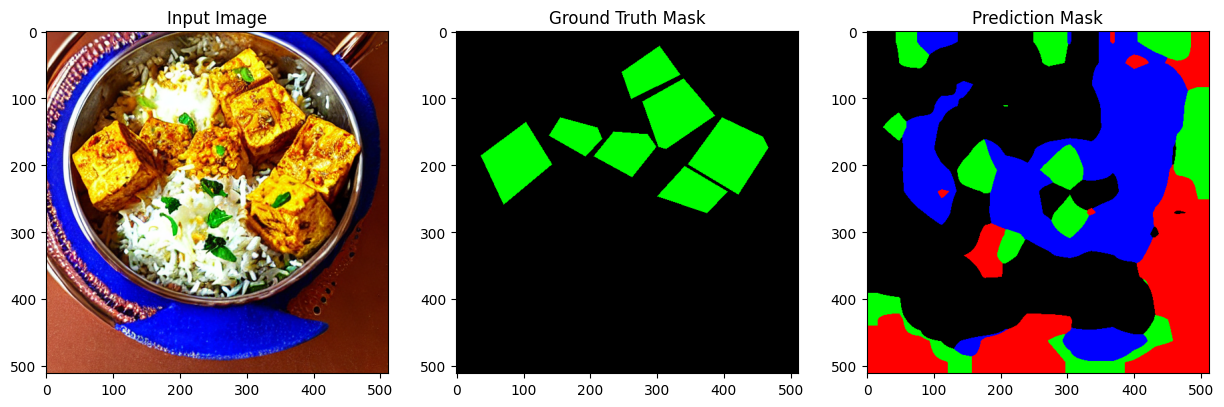

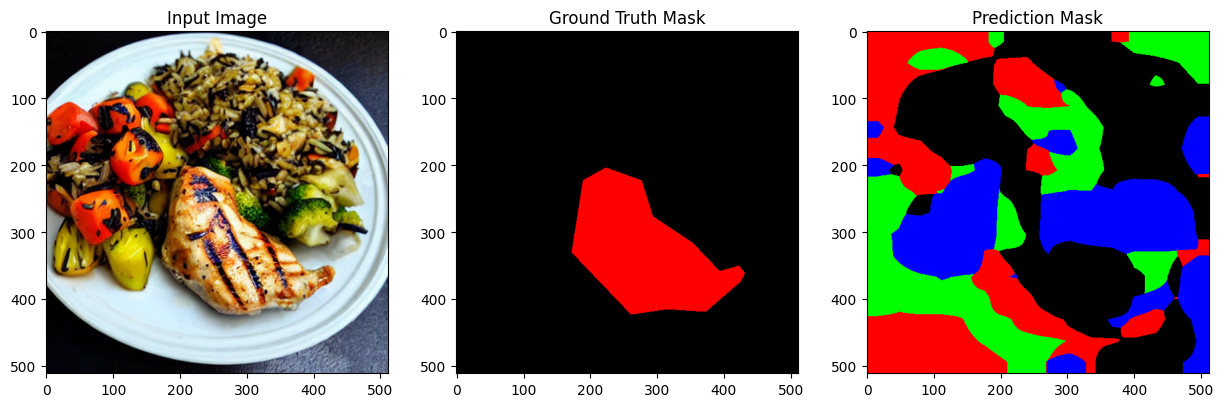

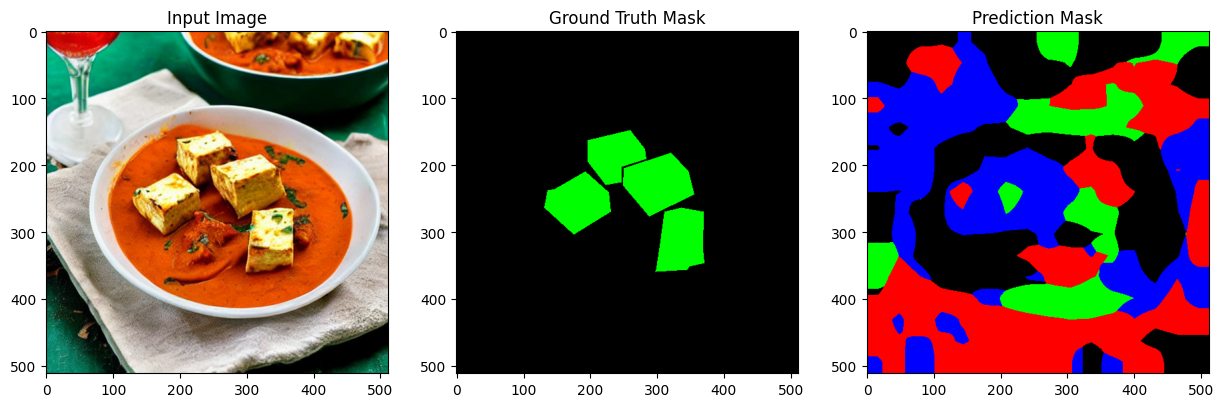

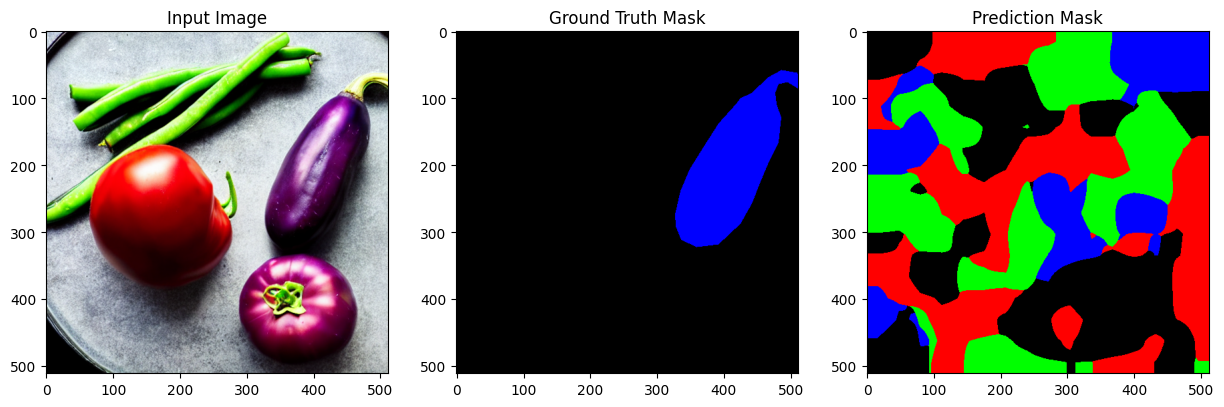

In [23]:
# Evaluate and visualize
print("Average Training Loss:", train_loss)
print("Average Validation Loss:", val_loss)
print("Visualizing Predictions on Validation Data:")
visualize_predictions(model, val_loader)